In [54]:
%%capture
!pip install transformers datasets

In [55]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import random
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [56]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [57]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


In [58]:
def preprocessing_fn(x, tokenizer):
    x["review_token"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x


Same celel than in the lab session.

🚧 **TODO** 🚧

Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [59]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle(seed=42)

# Select 5000 samples
dataset = dataset.select(range(n_samples))

# Tokenize the dataset
dataset = dataset.map(
    lambda x: preprocessing_fn(x, tokenizer),
    batched=False,
    num_proc=4,
)
# Remove useless columns
dataset = dataset.remove_columns(["review", "sentiment"])

# Split the train and validation
train_size = int(0.8 * len(dataset))

document_train_set = dataset.select(range(train_size))
document_valid_set = dataset.select(range(train_size, len(dataset)))


In [60]:
def extract_words_contexts(ids_list, R):
    """
    Extract pairs of review_ids and their contexts from a list of review_ids.

    Args:
        ids_list (list): A list of review_ids.
        R (int): Radius for the context window (number of review_ids before and after each review).

    Returns:
        tuple: Two lists -
               1) List of review_ids.
               2) List of lists, where each inner list represents the context C+ of size 2R for each review_id.
    """
    words = []
    contexts = []

    for review in ids_list:
        for i in range(len(review)):
            w = review[i]

            # Extract the context window
            start = max(0, i - R)
            end = min(len(review), i + R + 1)

            # Create the context by taking elements before and after the current element
            context = review[start:i] + review[i + 1:end]

            # Pad the context to ensure it's exactly 2R in length
            left_padding = max(0, R - i)  # Amount of padding needed on the left
            right_padding = max(0, (i + R + 1) - len(review))  # Padding on the right

            context = [0] * left_padding + context + [0] * right_padding

            #context = [item for sublist in [context] for item in sublist]
            # Ensure final context length is exactly 2R
            context = context[:2 * R]

            words.append(w)
            contexts.append(context)

    return words, contexts


def flatten_dataset_to_list(data, R):
    """
    Apply extract_words_contexts on the entire dataset and flatten the output into lists.

    Args:
        data (DataFrame): A pandas DataFrame with a column 'review_ids'.
        R (int): Radius for the context window (number of review_ids before and after each review).

    Returns:
        list: A flattened list of review_ids.
        list: A flattened list of their corresponding contexts (each context being a list).
    """

    words, contexts = [], []
    for i in tqdm(range(len(data)), desc="Processing dataset"):
        words_, contexts_ = extract_words_contexts([data["review_token"][i]], R)
        words.extend(words_)
        contexts.extend(contexts_)
    return words, contexts


In [61]:
# Sanity check that all the contexts are of the same length
print(len(dataset[3]["review_token"]))
word, contexts = extract_words_contexts([dataset['review_token'][3]], 10)
print(len(contexts[0]), len(contexts[10]), len(contexts[-1]))


253
20 20 20


In [62]:
######### FOR FASTER PROCESSING -> REDUCE DATASET SIZE #########
if True:
    document_train_set = document_train_set.select(range(1000))
    document_valid_set = document_valid_set.select(range(100, 300))

train_dataset_words, train_dataset_contexts = flatten_dataset_to_list(
    document_train_set, 5
)

valid_dataset_words, valid_dataset_contexts = flatten_dataset_to_list(
    document_valid_set, 5
)

Processing dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing dataset:   0%|          | 0/200 [00:00<?, ?it/s]

In [63]:
class Word2VecDataset(Dataset):
    def __init__(self, words, contexts):
        assert len(words) == len(
            contexts
        ), "Words and contexts should have the same length"
        self.words = words
        self.contexts = contexts

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        return self.words[idx], self.contexts[idx]


train_dataset = Word2VecDataset(train_dataset_words, train_dataset_contexts)
valid_dataset = Word2VecDataset(valid_dataset_words, valid_dataset_contexts)
print(train_dataset[16])


(5956, [2521, 1007, 2055, 3011, 2386, 5146, 1010, 2934, 23564, 8024])


In [64]:
# TODO: Values of the dict should be torch tensors
# TODO: Handle batch size > 1
def collate_fn(batch, scaling_factor: int, vocab_size: int):
    batch_size = len(batch)
    review_token = torch.tensor([b[0] for b in batch])
    positive_context_ids = torch.tensor([b[1] for b in batch])
    positive_context_ids_set = set(positive_context_ids.flatten().tolist())
    negative_candidates = list(set(range(vocab_size)) - positive_context_ids_set)
    negative_context_ids = [
        random.sample(
            negative_candidates, scaling_factor * positive_context_ids.size(1)
        )
        for _ in range(batch_size)
    ]
    negative_context_ids = torch.tensor(negative_context_ids)
    result = {
        "review_token": review_token,
        "positive_context_ids": positive_context_ids,
        "negative_context_ids": negative_context_ids,
    }
    return result

print(tokenizer.vocab_size)

30522


In [65]:
 with open("config.yaml", 'r') as file:
        config = yaml.safe_load(file)

In [66]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= config["Word2Vec_model"]["batch_size"],
    shuffle=True,
    collate_fn=lambda batch: collate_fn(
        batch, scaling_factor=config["Word2Vec_model"]["ratio"], vocab_size=tokenizer.vocab_size
    ),
)

# Defining the model 

In [67]:
class Word2Vec(nn.Module):
    def __init__(self, embedding_dim: int, vocab_size: int, device = torch.device("mps")):
        super(Word2Vec, self).__init__()
        self.in_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx= 0).to(device)
        self.out_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx= 0).to(device)
        self.device = device


    def forward(self, target_word_ids, context_word_ids):
        embedded_target = self.in_embedding(target_word_ids)
        embedded_context = self.out_embedding(context_word_ids)

        # computation of the sigmoid of the dot product along the batch dimension (dim=2)
        score = torch.sigmoid(torch.sum(embedded_context*embedded_target, dim=2))
        return score

In [68]:
def validation(model, valid_dataloader):

    # Tracking variables
    total_size = 0
    acc_total = 0
    loss_total = 0
    criterion = nn.BCELoss(reduction = 'none') # setting the reduction to none in order to not compute the mean outside the BCE Loss rather than inside

    # Set model to evaluation mode
    model.eval()

    # ========== Evaluation ==========

    with torch.no_grad():
        for batch in tqdm(valid_dataloader):

            # Pushing the batches to the computing device
            review_token = batch["review_token"].to(model.device)
            positive_context_ids = batch["positive_context_ids"].to(model.device)
            negative_context_ids = batch["negative_context_ids"].to(model.device)

            # Calculating the loss
            """ Note that the .unsqueeze(1) is used so that the score can be calculated. """
            pred_pos = model(review_token.unsqueeze(1), positive_context_ids) # positive context prediction
            pred_neg = model(review_token.unsqueeze(1), negative_context_ids) # negative context prediction
            """ For loss_positive and loss_negative, the mean of all BCE Losses for the positive/negative context predictions is computed. """
            loss_positive = torch.mean(criterion(pred_pos, torch.ones(pred_pos.shape, device=model.device)), dim=1)
            loss_negative = torch.mean(criterion(pred_neg, torch.zeros(pred_neg.shape, device=model.device)), dim=1)
            loss = torch.mean(loss_positive + loss_negative)
            loss_total += loss.detach().cpu().item()

            # Calculating the accuracy
            """ The threshold for the BCE Loss is set to 0.5. Under, the prediction is considered negative, and over positive """
            acc_positive = (pred_pos.squeeze() > 0.5)
            acc_negative = (pred_neg.squeeze() < 0.5)
            acc_total += acc_positive.int().sum().item()
            acc_total += acc_negative.int().sum().item() # summing the number of Trues
            total_size += acc_positive.numel()
            total_size += acc_negative.numel() # adding up all the predictions done

    # Set the model back to training mode
    model.train()

    return loss_total / len(valid_dataloader), acc_total / total_size

In [69]:
def training(model, batch_size, n_epochs, lr=5e-5):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-08,
    )

    train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size= config["Word2Vec_model"]["batch_size"],
            shuffle=True,
            collate_fn=lambda batch: collate_fn(
                batch, scaling_factor=config["Word2Vec_model"]["ratio"], vocab_size=tokenizer.vocab_size))

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=config["Word2Vec_model"]["batch_size"],
        shuffle=False,
        collate_fn= lambda batch: collate_fn(
                batch, scaling_factor=config["Word2Vec_model"]["ratio"], vocab_size=tokenizer.vocab_size))

    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []
    criterion = nn.BCELoss(reduction = 'none') # setting the reduction to none in order to not compute the mean outside the BCE Loss rather than inside

    for e in range(n_epochs):

        # ========== Training ==========

        # Set model to training mode
        model.train()

        # Tracking variables
        train_loss = 0
        epoch_train_acc = 0
        total_size = 0
        for batch in tqdm(train_dataloader):
            # Pushing the batches to the computing device
            review_token, positive_context_ids, negative_context_ids = (
                batch["review_token"].to(model.device),
                batch["positive_context_ids"].to(model.device),
                batch["negative_context_ids"].to(model.device),
            )

            optimizer.zero_grad()
            #print(review_token.device, positive_context_ids.device, negative_context_ids.device)
            # Forward pass
            output_positive = model(review_token.unsqueeze(1), positive_context_ids)
            output_negative = model(review_token.unsqueeze(1), negative_context_ids)

            # Backward pass

            # Calculating the loss as in the validation function
            loss_positive = torch.mean(criterion(output_positive, torch.ones(output_positive.shape, device= model.device)), dim=1)
            loss_negative = torch.mean(criterion(output_negative, torch.zeros(output_negative.shape, device= model.device)), dim=1)
            loss = torch.mean(loss_positive + loss_negative)

            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()

            # Calculating the accuracy as in the validation function
            acc_positive = (output_positive.squeeze() > 0.5)
            acc_negative = (output_negative.squeeze() < 0.5)
            epoch_train_acc += acc_positive.int().sum().item()
            epoch_train_acc += acc_negative.int().sum().item()
            total_size += acc_positive.numel()
            total_size += acc_negative.numel()

        list_train_acc.append(epoch_train_acc / total_size)
        list_train_loss.append(train_loss / len(train_dataloader))

        # ========== Validation ==========

        l, a = validation(model, valid_dataloader)
        list_val_loss.append(l)
        list_val_acc.append(a)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a),
        )

    return list_train_loss, list_train_acc, list_val_loss, list_val_acc


In [70]:
 with open("config.yaml", 'r') as file:
        config = yaml.safe_load(file)
word2vec = Word2Vec(embedding_dim=config["Word2Vec_model"]["embedding_dim"], vocab_size=tokenizer.vocab_size + 1, device = torch.device("mps"))

# Training the model and evaluate it

In [71]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(model = word2vec, batch_size = config["Word2Vec_model"]["batch_size"], n_epochs = 20, lr = 1e-3)


  0%|          | 0/205953 [00:00<?, ?it/s]

TypeError: 'int' object is not subscriptable

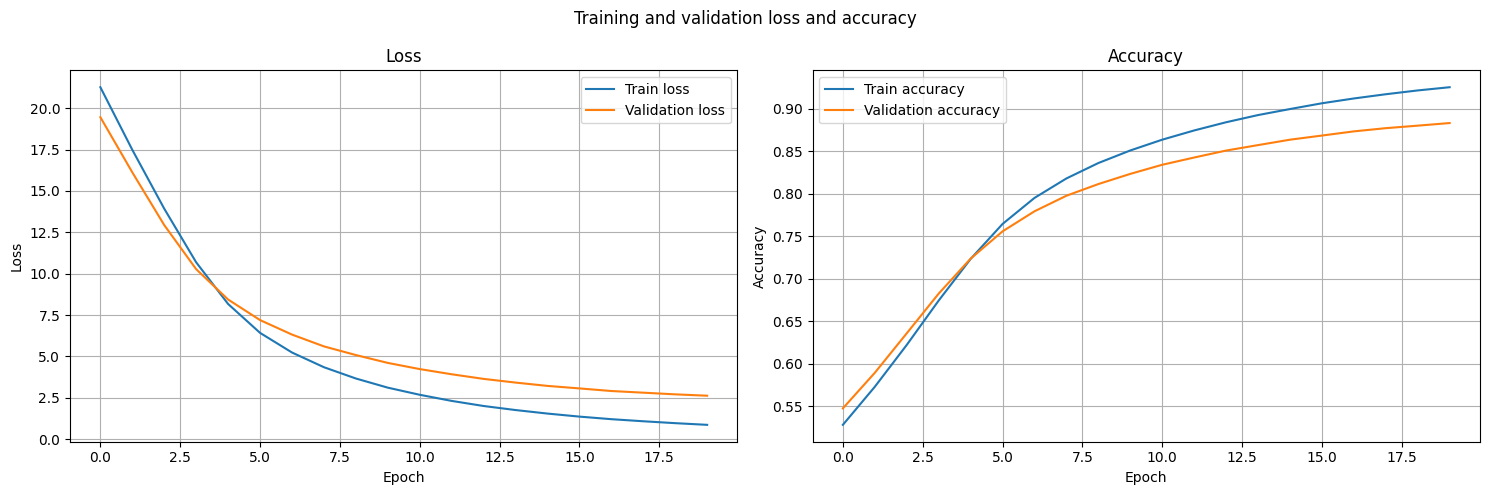

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].grid(True)
ax[1].grid(True)
ax[0].plot(list_train_loss, label="Train loss")
ax[0].plot(list_val_loss, label="Validation loss")
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(list_train_acc, label="Train accuracy")
ax[1].plot(list_val_acc, label="Validation accuracy")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
fig.suptitle("Training and validation loss and accuracy")
plt.tight_layout()
plt.show()

In [53]:
def save_model(model, path):
    torch.save(model.state_dict(), path)


if True:
    save_model(
        model = word2vec,
        path = f"model_dim-{config['Word2Vec_model']['embedding_dim']}-radius-{config['Word2Vec_model']['R']}-ratio-{config['Word2Vec_model']['ratio']}-batch-{config['Word2Vec_model']['batch_size']}-epoch-{config['Word2Vec_model']['num_epochs']}.ckpt"
        )